In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [2]:
import os
import pickle

raw_files = [(x[0], x[2]) for x in os.walk('../raw')][0]
raw_files

('../raw',
 ['(exh)-(simple-child)-(no-id).txt',
  '(ictsm)-(enhanced)-(no-id).txt',
  '(exh)-(enhanced)-(id).txt',
  '(exh-sort)-(enhanced)-(no-id).txt',
  '(ictsm)-(simple-child)-(no-id).txt',
  '(exh)-(enhanced)-(no-id).txt',
  '(ictsm)-(enhanced)-(id).txt'])

In [3]:
from collections import defaultdict
import pandas as pd
import re
result_maps = dict()
map_types = set()
for file in raw_files[1]:
    name = os.path.splitext(file)[0]
#     print(name)
    df = pd.read_csv("../raw/" + file)
    result_maps[name] = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    results = result_maps[name]
    for d in df.iterrows():
        data = d[1]
        setting = data[0]
#         print(setting)
        m = re.match('([A-Za-z]*)-20x20-A(\d+)_T(\d+)',setting)
        map_type = m.group(1)
        map_types.add(map_type)
        agents = int(m.group(2))
        teams = int(m.group(3))
#         print(map_type,agents,teams)
        results[map_type][teams][agents] = (data[2],data[1])
    print(results)
#     print(results)
# print(result_maps)
#         t = data[]
#         print(data[0])
#     print(df)
    
    

defaultdict(<function <lambda> at 0x7f8229b4b790>, {'Open': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f8228298160>, {1: defaultdict(<class 'dict'>, {1: (0.04087716658003046, 1.0), 2: (0.1178240344400001, 1.0), 3: (0.2949362189199655, 1.0), 4: (0.6464526957399721, 1.0), 5: (1.229350768819968, 1.0), 6: (2.079500480980032, 1.0), 7: (6.297281036399991, 0.96), 8: (9.271404551159986, 0.96), 9: (30.22005276408002, 0.04), 10: (31.508414999339987, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.029426009600010725, 1.0), 2: (0.0960418017000302, 1.0), 3: (0.12635718684002314, 1.0), 4: (0.2589295611000125, 1.0), 5: (0.4722273407000103, 1.0), 6: (0.7177396882000084, 1.0), 7: (1.3124405857600414, 1.0), 8: (2.931322815219973, 1.0), 9: (5.070171871160029, 0.98), 10: (10.069182242660016, 0.88)})}), 'Obstacle': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f82282e95e0>, {1: defaultdict(<class 'dict'>, {1: (0.020420880639958342, 1.0), 2: (0.1064081740599977, 1.0), 3: (0.21252604709999

1
Maze


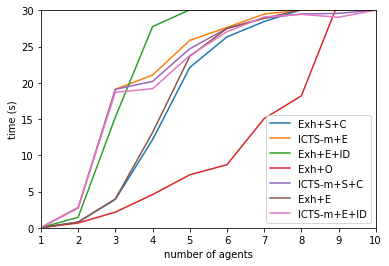

Open


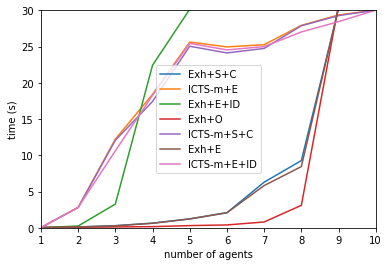

Obstacle


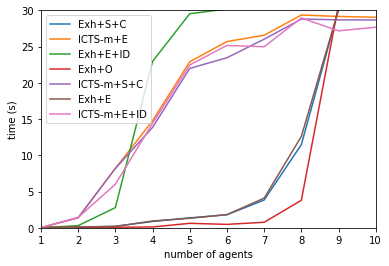

3
Maze


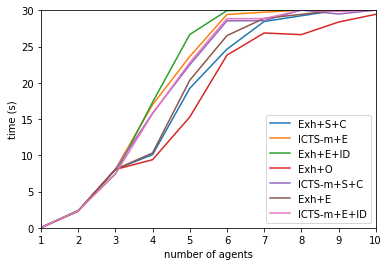

Open


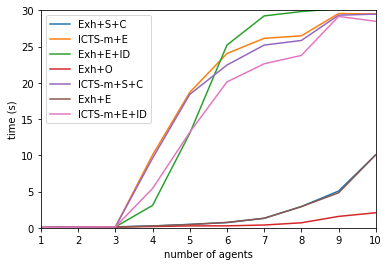

Obstacle


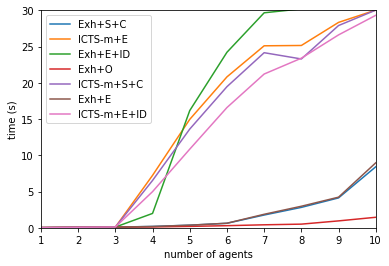

In [19]:
name_map = {
"(exh-sort)-(enhanced)-(no-id)": "Exh+O",
"(exh)-(enhanced)-(no-id)": "Exh+E",
"(ictsm)-(enhanced)-(no-id)": "ICTS-m+E",
"(exh)-(enhanced)-(id)": "Exh+E+ID",
"(ictsm)-(enhanced)-(id)": "ICTS-m+E+ID",
"(exh)-(simple-child)-(no-id)": "Exh+S+C",
"(ictsm)-(simple-child)-(no-id)": "ICTS-m+S+C",
}
for team_size in [1,3]:
    print(team_size)
    for map_type in map_types:
        plt.axis([1, 10, 0, 30])
        print(map_type)
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: x[0],data.values()))
#             print(times)
            plt.plot(keys,values, label = name_map[name])
        plt.xlabel('number of agents')
        plt.ylabel('time (s)')
        plt.legend()
        plt.savefig("{}-{}".format(map_type.lower(),team_size))
        plt.show()

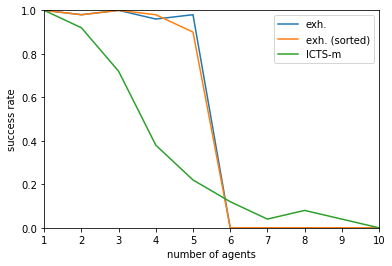

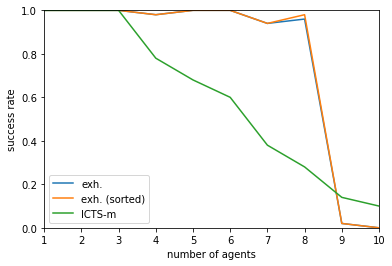

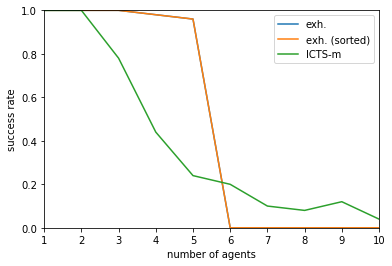

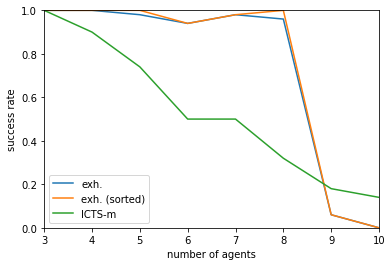

In [95]:
# data = np.arange(60)
solvers = dict()
solvers["exh."] = dict()
solvers["exh. (sorted)"] = dict()
solvers["ICTS-m"] = dict()

one_results = dict()
one_results["open"] = dict()
one_results["obstacles"] = dict()
three_results = dict()
three_results["open"] = dict()
three_results["obstacles"] = dict()
for (algo,path) in [("exh.","enum_results.txt"),("exh. (sorted)","enum_sorted_results.txt"),("ICTS-m","results.txt")]:
    df = pd.read_csv("../results/map-sets/" + path)
    data = df[["completed","avg","std"]].to_numpy()
    one_results["open"][algo] = data[0:10]
    three_results["open"][algo] = data[10:20]
    one_results["obstacles"][algo] = data[20:30]
    three_results["obstacles"][algo] = data[30:40]

plt.axis([1, 10, 0, 1])
for k in one_results["open"]:
    plt.plot(list(range(1,11)),one_results["open"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 1])
for k in three_results["open"]:
    plt.plot(list(range(1,11)),three_results["open"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 1])
for k in one_results["obstacles"]:
    plt.plot(list(range(1,11)),one_results["obstacles"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()

plt.axis([3, 10, 0, 1])
for k in three_results["obstacles"]:
    plt.plot(list(range(3,11)),three_results["obstacles"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()
# plt.axis([1, 10, 0, 1])
# for k in one_results:
# #     print(k,results_map["open"][k])
#     plt.plot(list(range(1,11)),three_results[k][:,0], label = k)
# plt.xlabel('number of agents')
# plt.ylabel('success rate')
# plt.legend()
# plt.show()

#         print(data[20 * i + 1:20 + 20 * i:2])

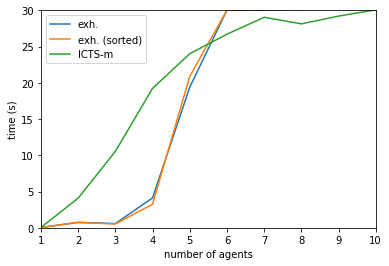

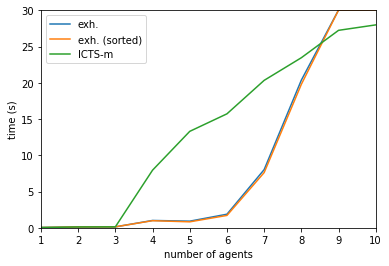

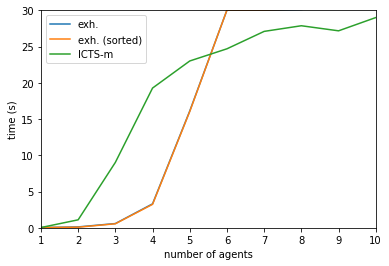

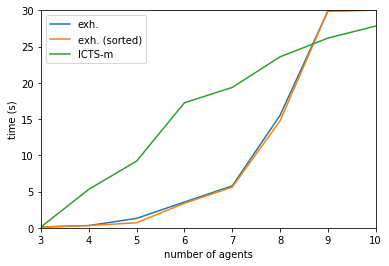

In [97]:
plt.axis([1, 10, 0, 30])
for k in one_results["open"]:
    plt.plot(list(range(1,11)),one_results["open"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 30])
for k in three_results["open"]:
    plt.plot(list(range(1,11)),three_results["open"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 30])
for k in one_results["obstacles"]:
    plt.plot(list(range(1,11)),one_results["obstacles"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()

plt.axis([3, 10, 0, 30])
for k in three_results["obstacles"]:
    plt.plot(list(range(3,11)),three_results["obstacles"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()